<a href="https://colab.research.google.com/github/aarsanjani/AlternusVera/blob/master/BERT_Multi_Class_Classification_Liar_Liar_NoDistillv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Multi-Class Classification with Liar-Liar dataset



# Part I - Dataset & Tokenization
---------------------------------

## S1. Setup


### 1.1. Connecting GPU


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### 1.2. Installing `transformers` from huggingface



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. 

In [ ]:
!pip install transformers

## S2. Retrieve & Inspect Dataset



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
liar_train_df = pd.read_csv('/content/drive/My Drive/NLPData/train.tsv', sep='\t', header=None)
liar_test_df = pd.read_csv('/content/drive/My Drive/NLPData/test.tsv', sep='\t', header=None) 
liar_valid_df = pd.read_csv('/content/drive/My Drive/NLPData/valid.tsv', sep='\t', header=None) 

In [ ]:
liar_train_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
liar_test_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [ ]:
liar_valid_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


Renaming the columns

In [ ]:
liar_test_df = liar_test_df.rename(columns={0: "ID", 1: "target", 2: "text", 3: "subjects", 4: "speaker", 5: "job", 6: "state", 7: "party", 8: "barely_true_count", 9: "false_count", 10: "half_true_count", 11: "mostly_true_count", 12: "pants_on_fire_count", 13: "target_names"})

In [ ]:
liar_train_df = liar_train_df.rename(columns={0: "ID", 1: "target", 2: "text", 3: "subjects", 4: "speaker", 5: "job", 6: "state", 7: "party", 8: "barely_true_count", 9: "false_count", 10: "half_true_count", 11: "mostly_true_count", 12: "pants_on_fire_count", 13: "target_names"})

In [ ]:
#Combining the text and speaker columns into one statement
liar_test_new = liar_test_df.copy()
liar_test_new['data']=liar_test_df['text']+'. '+liar_test_df['speaker']
liar_test_new = liar_test_new.drop(columns=['ID', 'text','subjects','speaker','job','state','party','barely_true_count','false_count','half_true_count','mostly_true_count','pants_on_fire_count'])

liar_train_new = liar_train_df.copy()
liar_train_new['data']=liar_train_df['text']+'. '+liar_train_df['speaker']
liar_train_new = liar_train_new.drop(columns=['ID', 'text','subjects','speaker','job','state','party','barely_true_count','false_count','half_true_count','mostly_true_count','pants_on_fire_count'])



In [ ]:
def liar_truthdist_subj(subj=None, ax=None, saveplot=True, longtitle=True):
    """
    Plots the truth distribution of the LIAR dataset, optionally by subject
    Return the dataframe representing the plot, and the seaborn plot obj
    """   
    if not ax:
        fig, ax = plt.subplots()

    if subj == None:
        subj_filter = liar_train_new['subjects'].apply(lambda x: True)
        plt_title = 'distribution of truth values'
        filename = './image/liar_truthvals_dist.png'
    else:
        subj_filter = liar_train_new['subject_list'].apply(lambda entry: subj in entry)
        if longtitle:
            plt_title = '"' + subj + '": distribution of truth values'
        else:
            plt_title = subj
        filename = './image/liar_truthvals_dist_' + subj + '.png'
    
    subj_truthdist = pd.DataFrame({'label': liar_label, 'count': label_count} 
                                  for liar_label, label_count 
                                  in zip(liar_label_order, liar_train[subj_filter]['label'].value_counts()))
    
    sns.barplot(data=subj_truthdist, y='label', x='count', palette='coolwarm', ax=ax).set(title=plt_title, xlabel='count')
    plt.tight_layout()

    if saveplot:
        plt.savefig(filename)

    return subj_truthdist, ax

In [ ]:
for i in range(len(liar_test_new)):
    if liar_test_new.loc[i, 'target'] == "true": #REAL => 0
        liar_test_new.loc[i, 'target'] = 0
    elif liar_test_new.loc[i, 'target'] == "mostly-true": #mostly-true => 1
        liar_test_new.loc[i, 'target'] = 1
    elif liar_test_new.loc[i, 'target'] == "barely-true": #barely-true => 2
        liar_test_new.loc[i, 'target'] = 2
    elif liar_test_new.loc[i, 'target'] == "half-true": #half-true => 3
        liar_test_new.loc[i, 'target'] = 3
    elif liar_test_new.loc[i, 'target'] == "false": #false => 4
        liar_test_new.loc[i, 'target'] = 4
    elif liar_test_new.loc[i, 'target'] == "pants-fire": #pants-fire => 5
        liar_test_new.loc[i, 'target'] = 5            
    if liar_test_new.loc[i, 'data'] == "":
        liar_test_new = liar_test_new.drop([i])
liar_test_new.head()

,target,target_names,data
0,0,Radio interview,Building a wall on the U.S.-Mexico border will...
1,4,a news conference,Wisconsin is on pace to double the number of l...
2,4,comments on ABC's This Week.,Says John McCain has done nothing to help the ...
3,3,a radio show,Suzanne Bonamici supports a plan that will cut...
4,5,a web video,When asked by a reporter whether hes at the ce...


In [ ]:
for i in range(len(liar_train_new)):
    if liar_train_new.loc[i, 'target'] == "true": #true => 0
        liar_train_new.loc[i, 'target'] = 0
    elif liar_train_new.loc[i, 'target'] == "mostly-true": #mostly true => 1
        liar_train_new.loc[i, 'target'] = 1
    elif liar_train_new.loc[i, 'target'] == "barely-true": #barely-true => 2
        liar_train_new.loc[i, 'target'] = 2
    elif liar_train_new.loc[i, 'target'] == "half-true": #half-true => 3
        liar_train_new.loc[i, 'target'] = 3
    elif liar_train_new.loc[i, 'target'] == "false": #false => 4
        liar_train_new.loc[i, 'target'] = 4
    elif liar_train_new.loc[i, 'target'] == "pants-fire": #pants-fire => 5
        liar_train_new.loc[i, 'target'] = 5            
    if liar_train_new.loc[i, 'data'] == "":
        liar_train_new = liar_train_new.drop([i])
liar_train_new.head()

,target,target_names,data
0,4,a mailer,Says the Annies List political group supports ...
1,3,a floor speech.,When did the decline of coal start? It started...
2,1,Denver,"Hillary Clinton agrees with John McCain ""by vo..."
3,4,a news release,Health care reform legislation is likely to ma...
4,3,an interview on CNN,The economic turnaround started at the end of ...


Dropping null value rows from the dataframe

In [ ]:
liar_train_new = liar_train_new.dropna()
liar_test_new = liar_test_new.dropna()

In [ ]:
import sklearn.utils
from sklearn.utils import Bunch
tlabels = liar_test_new['target'].to_numpy()
#labels = labels.to_numpy() 
type(tlabels)
tdata = liar_test_new['data'].tolist()
type(tdata)
tdata_names = liar_test_new['target_names'].tolist()
test = Bunch(target=tlabels, data=tdata, target_names=tdata_names)
test.target = test.target.astype(int)

In [ ]:
import sklearn.utils
from sklearn.utils import Bunch
labels = liar_train_new['target'].to_numpy()
#labels = labels.to_numpy() 
type(labels)
data = liar_train_new['data'].tolist()
type(data)
data_names = liar_train_new['target_names'].tolist()
train = Bunch(target=labels, data=data, target_names=data_names)
train.target = train.target.astype(int)

In [ ]:
import textwrap
import random

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

# Randomly choose some examples.
for i in range(10):
    
    # Choose a random sample by index.
    j = random.choice(range(len(train.data)))
    print(j)
    # Get the text as 'x' and the label integer as 'y'.
    x = train.data[j]
    y = train.target[j]

    # Print out the name of the category and the text.
    print('')
    print('========', train.target_names[y], '========')
    print(wrapper.fill(x))
    print('')


8727

======== a news release ========
Jimmy Langevin is having a fundraiser . . . to retire the debt from his campaign
for secretary of state, which was 12 years ago.. john-matson

4161

======== a mailer ========
The property appraisers budget is $1 million less today than when I took office
16 years ago.. rob-turner

8669

======== Denver ========
Under Scott Walker, Wisconsin moved from 16th to third in percentage of people
with student loan debt.. scot-ross

8873

======== a mailer ========
Says McCain once said that on "the most important issues of our day, I've been
totally in agreement and support of President Bush.". joe-biden

4531

======== a mailer ========
America is No. 1one in oil and gas.. barack-obama

6172

======== Denver ========
Georgia lawmakers are now considering passing the most extreme gun bill in
America.. americans-responsible-solutions

7676

======== an interview on CNN ========
The Clintons now charge the Secret Service $10,000 monthly rent for the use of

Let's look at the classes to see how balanced they are.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of Training Samples')

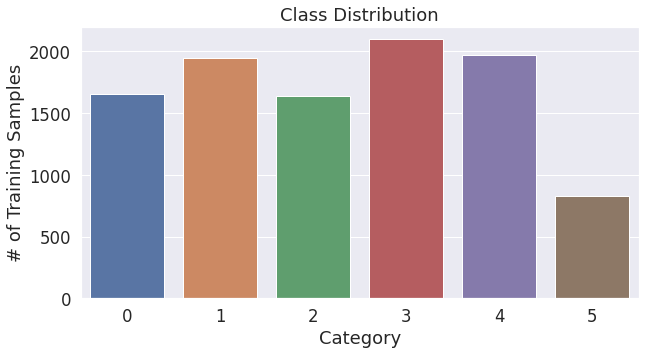

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)


# Plot the number of tokens of each length.
sns.countplot(train.target)
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('# of Training Samples')


They look pretty even, except for maybe class 5, which corresponds to 'a an online opinion-piece'.

In [ ]:
train.target_names[5]

'a an online opinion-piece'

## S3. Tokenization

BERT has a maximum input length of 512 tokens, so we'll need to truncate any comments which are longer than this.


### 3.1. Load BertTokenizer

preprocess the data for BERT to be able to analyze it.

In order to see the distribution of comment lengths *in terms of BERT tokens*, we'll need to first apply the BertTokenizer to the dataset.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


### 3.2. Sequence Length Distribution

To decide on a truncation strategy for this dataset, let's first look at the distribution of sequence lengths.

To do this, our first step is to tokenize all of the samples in the training set.

**Tokenize All Samples**

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

In [ ]:
import numpy as np

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# Record the length of each sequence (in terms of BERT tokens).
lengths = []

print('Tokenizing comments...')

# For every sentence...
for sen in train.data:
    
    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

    # Record the non-truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')
print('{:>10,} comments'.format(len(input_ids)))

Tokenizing comments...
  Read 0 comments.


Token indices sequence length is longer than the specified maximum sequence length for this model (719 > 512). Running this sequence through the model will result in indexing errors


DONE.
    10,138 comments


Print the min, max and median sentence lengths

In [ ]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 8 tokens
   Max length: 719 tokens
Median length: 28.0 tokens


What percentage are over the 512 limit?

In [ ]:
num_over = 0

# For all of the length values...
for length in lengths:
    # Tally if it's over 512.
    if length > 512:
        num_over += 1

print('{:,} of {:,} comments will be truncated ({:.2%})'.format(num_over, len(lengths), float(num_over) / float(len(lengths))))

1 of 10,138 comments will be truncated (0.01%)


To further analyze it, let's plot the distribution. To keep the scale of the x-axis reasonable, *we'll clip the lengths to 512.*


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of Comments')

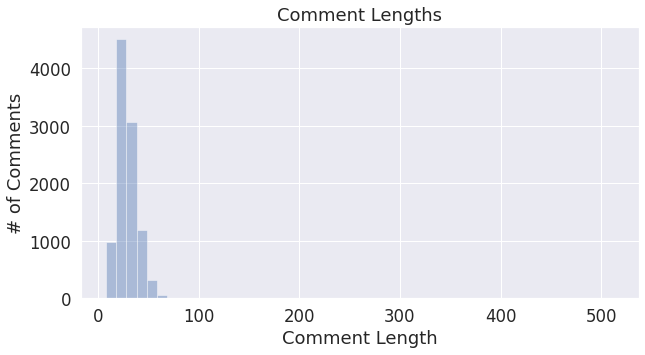

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any comment lengths greater than 512.
trunc_lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(trunc_lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is 
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('# of Comments')


In [ ]:
max_len = 300

### 3.3. Perform Tokenization

Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). 


In [ ]:
# Tokenize a dataset of comments.

# Parameters:
#  `comments` - List of comments, represented as strings.
#  `labels` - List of integer labels for the corresponding comments.
#  `max_len` - Truncate all of the comments down to this length.
    
# Returns:
#  `input_ids` - All of the comments represented as lists of token IDs,
#               padded out to `max_len`, and cast as a PyTorch tensor.
#  `labels` - The labels for the corresponding comments, formatted as 
#              a PyTorch tensor.
#  `attention_masks` - PyTorch tensor with the same dimensions as
#                     `input_ids`. For each token, simply indicates whether
#                      it is padding or not.

comments = train.data
labels   = train.target

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Tokenizing {:,} comments...'.format(len(comments)))

    # For every comment ("sentence")...
for sent in comments:

        # Report progress.
        if ((len(input_ids) % 500) == 0):
            print('  Tokenized {:,} comments.'.format(len(input_ids)))

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,      # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Convert the labels to a tensor.
labels = torch.tensor(torch.from_numpy(labels))
print(labels)

(train_input_ids, 
 train_labels, 
 train_attention_masks) = (input_ids, labels, attention_masks)


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing 10,138 comments...
  Tokenized 0 comments.


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  Tokenized 500 comments.
  Tokenized 1,000 comments.
  Tokenized 1,500 comments.
  Tokenized 2,000 comments.
  Tokenized 2,500 comments.
  Tokenized 3,000 comments.
  Tokenized 3,500 comments.
  Tokenized 4,000 comments.
  Tokenized 4,500 comments.
  Tokenized 5,000 comments.
  Tokenized 5,500 comments.
  Tokenized 6,000 comments.
  Tokenized 6,500 comments.
  Tokenized 7,000 comments.
  Tokenized 7,500 comments.
  Tokenized 8,000 comments.
  Tokenized 8,500 comments.
  Tokenized 9,000 comments.
  Tokenized 9,500 comments.
  Tokenized 10,000 comments.
tensor([4, 3, 1,  ..., 3, 4, 5])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Now we'll use the above function to actually perform the tokenization of the training comments.

In [ ]:
# Print sentence 0, now as a list of IDs.
print('Original: ', train.data[0])
print('Token IDs:', train_input_ids[0])

Original:  Says the Annies List political group supports third-trimester abortions on demand.. dwayne-bohac
Token IDs: tensor([  101,  2758,  1996,  8194,  2015,  2862,  2576,  2177,  6753,  2353,
         1011, 12241, 20367, 11324,  2015,  2006,  5157,  1012,  1012,  1040,
         4576,  2638,  1011,  8945,  3270,  2278,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  

Let's also tokenize the test dataset 

In [ ]:
# Tokenize a dataset of comments.

# Parameters:
#  `comments` - List of comments, represented as strings.
#  `labels` - List of integer labels for the corresponding comments.
#  `max_len` - Truncate all of the comments down to this length.
    
# Returns:
#  `input_ids` - All of the comments represented as lists of token IDs,
#               padded out to `max_len`, and cast as a PyTorch tensor.
#  `labels` - The labels for the corresponding comments, formatted as 
#              a PyTorch tensor.
#  `attention_masks` - PyTorch tensor with the same dimensions as
#                     `input_ids`. For each token, simply indicates whether
#                      it is padding or not.

comments = test.data
labels   = test.target

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Tokenizing {:,} comments...'.format(len(comments)))

    # For every comment ("sentence")...
for sent in comments:

        # Report progress.
        if ((len(input_ids) % 500) == 0):
            print('  Tokenized {:,} comments.'.format(len(input_ids)))

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,      # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Convert the labels to a tensor.
labels = torch.tensor(torch.from_numpy(labels))
print(labels)

(test_input_ids, 
 test_labels, 
 test_attention_masks) = (input_ids, labels, attention_masks)


Tokenizing 1,250 comments...
  Tokenized 0 comments.


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  Tokenized 500 comments.
  Tokenized 1,000 comments.
tensor([0, 4, 4,  ..., 2, 2, 4])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Part II - BERT Fine-Tuning

## S4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

### `check_gpu_mem`

The following function will return a table showing the GPU's current memory usage versus its total memory. It uses the `nvidia-smi` command line tool to retrieve this.

Note that the memory values are in "MiB". 1 MiB = 2^20 bytes = 1,048,576 bytes.

In [ ]:
import os
import pandas as pd
import csv

def check_gpu_mem():
    '''
    Uses Nvidia's SMI tool to check the current GPU memory usage.
    Reported values are in "MiB". 1 MiB = 2^20 bytes = 1,048,576 bytes.
    '''
    
    # Run the command line tool and get the results.
    buf = os.popen('nvidia-smi --query-gpu=memory.total,memory.used --format=csv')

    # Use csv module to read and parse the result.
    reader = csv.reader(buf, delimiter=',')

    # Use a pandas table just for nice formatting.
    df = pd.DataFrame(reader)

    # Use the first row as the column headers.
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header

    # Display the formatted table.
    #display(df)

    return df


### 4.1. Load Pre-Trained Model

For text classification, we'll be using [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification). 



**Model Variant**

Using "bert-base-uncased" for this example, the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

During fine-tuning, the entire pre-trained BERT model and the additional untrained classification layer is trained. 

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 6, # For our 6 labels!
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
check_gpu_mem()

,memory.total [MiB],memory.used [MiB]
1,16280 MiB,1395 MiB


### 4.2. Splitting off a Validation Set


This dataset already has a train / test split, but we're going to further divide up our training set to use 90% for training and 10% for *validation*. This validation set will help us detect over-fitting during the training process.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

9,124 training samples
1,014 validation samples


### 4.3. Batch Size & DataLoaders

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

This is also the point at which we must specify our **batch size**, since this is integral to the data loaders.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### 4.4. Optimizer


Our `model` object handles the execution of a forward pass, and the calculation of gradients during training. 

The actual updates to the model's weights, however, are performed by an Optimizer object. Here, we create that object and give it a reference to our model's parameters, as well as set some of our training hyperparameters.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32 
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4). This is a parameter to the "learning rate scheduler" in the section.

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" 

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

### 4.5. Epochs & Learning Rate Scheduler

The learning rate scheduler is responsible for updating the learning rate over the course of the training. Generally speaking, you want the learning rate to gradually get smaller and smaller so that training makes gradually finer adjustments to the weights. 

This decay needs to happen *across all of the training epochs*, so this is where we need to specify the number of epochs we want to train for. 

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

**Helper Functions**

In each pass, we will train the model on our full training set, and then measure it's accuracy on our 10% holdout validation set. We'll define a helper function for calculating accuracy on the *validation* set.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


### 4.5. Training Loop



For addressing our **GPU memory issue**, Added some calls to `check_gpu_mem` during the training process. 

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Check GPU memory for the first couple steps.
        if step < 2:
            print('\n  Step {:} GPU Memory Use:'.format(step))
            df = check_gpu_mem()    
            print('    Before forward-pass: {:}'.format(df.iloc[0, 1]))

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Report GPU memory use for the first couple steps.
        if step < 2:
            df = check_gpu_mem()    
            print('     After forward-pass: {:}'.format(df.iloc[0, 1]))

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Report GPU memory use for the first couple steps.
        if step < 2:
            df = check_gpu_mem()    
            print('    After gradient calculation: {:}'.format(df.iloc[0, 1]))

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...

  Step 0 GPU Memory Use:
    Before forward-pass:  1395 MiB
     After forward-pass:  7045 MiB
    After gradient calculation:  7373 MiB

  Step 1 GPU Memory Use:
    Before forward-pass:  7643 MiB
     After forward-pass:  8433 MiB
    After gradient calculation:  8653 MiB
  Batch    50  of    571.    Elapsed: 0:00:26.
  Batch   100  of    571.    Elapsed: 0:00:52.
  Batch   150  of    571.    Elapsed: 0:01:17.
  Batch   200  of    571.    Elapsed: 0:01:43.
  Batch   250  of    571.    Elapsed: 0:02:09.
  Batch   300  of    571.    Elapsed: 0:02:34.
  Batch   350  of    571.    Elapsed: 0:03:00.
  Batch   400  of    571.    Elapsed: 0:03:25.
  Batch   450  of    571.    Elapsed: 0:03:51.
  Batch   500  of    571.    Elapsed: 0:04:17.
  Batch   550  of    571.    Elapsed: 0:04:42.

  Average training loss: 1.73
  Training epcoh took: 0:04:53

Running Validation...
  Accuracy: 0.25
  Validation Loss: 1.68
  Validation took: 0:00:11

======== E

Training accuracy should always go up, or at least remain constant, with each additional training epoch. 

We see that the validation accuracy has *increased* and *remained constant*, hence our model is not over-fitting. 

In [ ]:
import pandas as pd

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '50px')])])

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.73,1.68,0.25,0:04:53,0:00:11
2,1.61,1.70,0.27,0:04:53,0:00:11
3,1.44,1.74,0.27,0:04:53,0:00:11
4,1.26,1.82,0.27,0:04:53,0:00:11


Let's take a look at our training loss over all epochs:

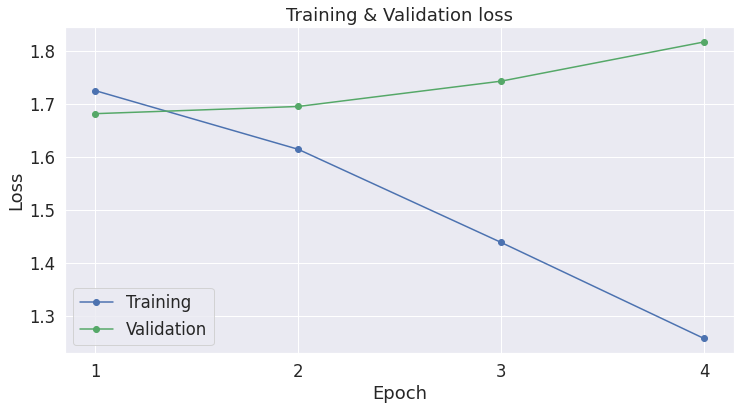

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

We do appear to be severely over-fitting from the third epoch.

# Part III - Performance & Analysis

## S5. Performance On Test Set

### 5.1. Baseline Implementation


The quick summary:
* It uses `tf-idf` for vectorization.
* It uses `multinomial naive bayes` for classification.
* F1 score: `0.221`   (on the test set)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Rename our dataset variables to be consistent with the example.
liar_liar_train = train
liar_liar_test = test

# Vectorize the text using tf-idf.
vectorizer = TfidfVectorizer()

# Before we can vectorize the text, the tf-idf model needs
# to analyze the dataset to build a vocabulary and word counts.
print('Analyzing dataset for tf-idf...\n')
vectorizer.fit(liar_liar_train.data)

# Convert the text samples into tf-idf vectors.
print('Vectorizing the text samples...\n')
vectors_train = vectorizer.transform(liar_liar_train.data)
vectors_test = vectorizer.transform(liar_liar_test.data)

print('{:>6,} train samples with {:<7,} features.'.format(vectors_train.shape[0], vectors_train.shape[1]))
print('{:>6,}  test samples with {:<7,} features.'.format(vectors_test.shape[0], vectors_test.shape[1]))

Analyzing dataset for tf-idf...

Vectorizing the text samples...

10,138 train samples with 13,915  features.
 1,250  test samples with 13,915  features.


In [ ]:
# Following the example, we'll use a "multinomial Naive Bayes" classifier.
clf = MultinomialNB(alpha=.01)

# Train the classifier on the training set.
print('Training the Naive Bays classifier...\n')
clf.fit(vectors_train, liar_liar_train.target)

# Run prediction on the test set.
print('Predicting labels for the test set...\n')
pred = clf.predict(vectors_test)

# Use the F1 metric to score our classifier's performance on the test set.
score = metrics.f1_score(liar_liar_test.target, pred, average='macro')

# Print the F1 score!
print('F1 score: {:.3}'.format(score))

Training the Naive Bays classifier...

Predicting labels for the test set...

F1 score: 0.221


### 5.2. Evaluate BERT on Test Set



Now we can apply our fine-tuned BERT model to generate predictions on the test set.

In [ ]:
# Create the DataLoaders.

# Combine the features into a dataset object.
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create a sequential sampler--no need to randomize the order!
test_sampler = SequentialSampler(test_data)

# Create the data loader.
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# Predict labels for all test set examples.

print('Predicting labels for {:,} test comments...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store the compute graph, saving memory
    # and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,250 test comments...
  Batch    50  of     79.    Elapsed: 0:00:08.
    DONE.


To turn our model outputs into actual predictions, we need to:

1. Re-combine the predictions from across all of the batches.
2. Pick a class label for each prediction by choosing the class with the highest output value.

In [ ]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Take the highest scoring output as the predicted label.
predicted_labels = np.argmax(predictions, axis=1)

print('`predictions` has shape', predictions.shape)
print('`predicted_labels` has shape', predicted_labels.shape)


`predictions` has shape (1250, 6)
`predicted_labels` has shape (1250,)


Let's peek at the model's outputs for the first 10 test samples, along with the correct labels for each.

In [ ]:
# Reduce printing precision for legibility.
np.set_printoptions(precision=2)

print("Predicted:", str(predicted_labels[0:10]))
print("  Correct:", str(true_labels[0:10]))

Predicted: [4 3 5 3 2 0 2 5 0 0]
  Correct: [0 4 4 3 5 0 0 2 0 2]


The metric for the Liar Liar dataset used by the scikit-learn example is the F1 score. Let's see how BERT performed!

In [ ]:
from sklearn import metrics

# Use the F1 metric to score our classifier's performance on the test set.
score = metrics.f1_score(true_labels, predicted_labels, average='macro')

# Print the F1 score!
print('F1 score: {:.3}'.format(score))

F1 score: 0.284


At this point, we have the following F1 scores:

Liar-Liar F1 Scores
* Naive Bayes: `0.221`
* BERT:  `0.284`

We've outperformed the baseline! 